In [ ]:
# Clone the repository to your Google Colab environment
!git clone https://github.com/MXHsj/rus_sim1.0.git

Cloning into 'rus_sim1.0'...
remote: Enumerating objects: 1894, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 1894 (delta 1), reused 3 (delta 0), pack-reused 1885 (from 2)
Receiving objects: 100% (1894/1894), 112.30 MiB | 8.39 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (1839/1839), done.


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from scipy.signal import wiener
from skimage.feature import match_template
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle
from skimage.morphology import disk
from skimage.filters import rank
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define the directory where your ultrasound images are stored
us_image_dir = '/content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/us'

# Get all the image files in the directory (filtering out non-image files)
image_files = [f for f in os.listdir(us_image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Check each image file
for img_file in image_files:
    img_path = os.path.join(us_image_dir, img_file)

    # Try to load the image in grayscale mode
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded successfully
    if img is None:
        print(f"Error loading image: {img_path}")
    else:
        print(f"Image loaded successfully: {img_path}")

Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/us/bmode_264.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/us/bmode_293.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/us/bmode_135.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/us/bmode_315.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/us/bmode_167.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/us/bmode_75.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/us/bmode_296.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/us/bmode_333.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/us/bmode_332.png
Image loaded successfully: /content/rus_sim1.0/

In [ ]:
# Define the directory where your CT images are stored
ct_image_dir = '/content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/ct'

# Get all the image files in the directory (filtering out non-image files)
image_files = [f for f in os.listdir(ct_image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Check each image file
for img_file in image_files:
    img_path = os.path.join(ct_image_dir, img_file)

    # Try to load the image in grayscale mode
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded successfully
    if img is None:
        print(f"Error loading image: {img_path}")
    else:
        print(f"Image loaded successfully: {img_path}")

Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/ct/ct_324.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/ct/ct_392.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/ct/ct_354.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/ct/ct_114.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/ct/ct_95.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/ct/ct_34.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/ct/ct_182.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/ct/ct_2.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/ct/ct_396.png
Image loaded successfully: /content/rus_sim1.0/ct2us/dataset/ct_slices_trans_

In [ ]:
def load_ultrasound_images(folder_path):
    image_paths = sorted(glob(os.path.join(folder_path, '*.png')))
    images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
            images.append(img)
    return images, image_paths

In [ ]:
def load_ct_images(folder_path):
    image_paths = sorted(glob(os.path.join(folder_path, '*.png')))
    images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
            images.append(img)
    return images, image_paths

In [ ]:
def apply_wavelet(images):
    return [denoise_wavelet(img, method='BayesShrink', mode='soft', wavelet_levels=3, rescale_sigma=True) for img in images]

In [ ]:
def apply_wiener(images):
    return [wiener(img, (5, 5)) for img in images]

In [ ]:
def apply_morph(images):
    morph_filtered = []
    selem = disk(2)  # you can experiment with radius
    for img in images:
        img_ubyte = (img * 255).astype(np.uint8)
        filtered = rank.median(img_ubyte, footprint=selem).astype(np.float32) / 255.0
        morph_filtered.append(filtered)
    return morph_filtered

In [ ]:
def analyze_denoising(folder_path, ct_folder_path):
    # Load the ultrasound and CT images
    imgs, _ = load_ultrasound_images(folder_path)
    ct_imgs, _ = load_ct_images(ct_folder_path)

    # Apply different denoising methods
    wavelet_denoised = apply_wavelet(imgs)
    wiener_denoised = apply_wiener(imgs)
    morph_denoised = apply_morph(imgs)

    # Compute metrics for each denoising method
    results = compute_metrics(imgs, ct_imgs, wavelet_denoised, 'Wavelet')
    results += compute_metrics(imgs, ct_imgs, wiener_denoised, 'Wiener')
    results += compute_metrics(imgs, ct_imgs, morph_denoised, 'Morphological')

    # Return the results as a DataFrame
    return pd.DataFrame(results)

In [ ]:
def compute_metrics(original_images, ct_images, denoised_images, method_name):
    metrics = []
    for orig, ct, den in zip(original_images, ct_images, denoised_images):
        # Compute SSIM between CT and denoised ultrasound
        ssim_val = ssim(ct, den, data_range=ct.max() - ct.min())

        # Compute PSNR between CT and denoised ultrasound
        psnr_val = psnr(ct, den, data_range=ct.max() - ct.min())

        # Compute Noise_STD between original CT and denoised ultrasound
        noise_std = np.std(ct - den)  # Note: using CT and denoised ultrasound

        # Append the results to the metrics list
        metrics.append({
            'Method': method_name,
            'SSIM': ssim_val,
            'PSNR': psnr_val,
            'Noise_STD': noise_std
        })

    return metrics

In [ ]:
def plot_comparison(df):
    plt.figure(figsize=(15, 6))
    for i, metric in enumerate(['SSIM', 'PSNR', 'Noise_STD']):
        plt.subplot(1, 3, i+1)
        sns.boxplot(x='Method', y=metric, data=df)
        plt.title(metric)
        plt.grid(True)
    plt.tight_layout()
    plt.show()

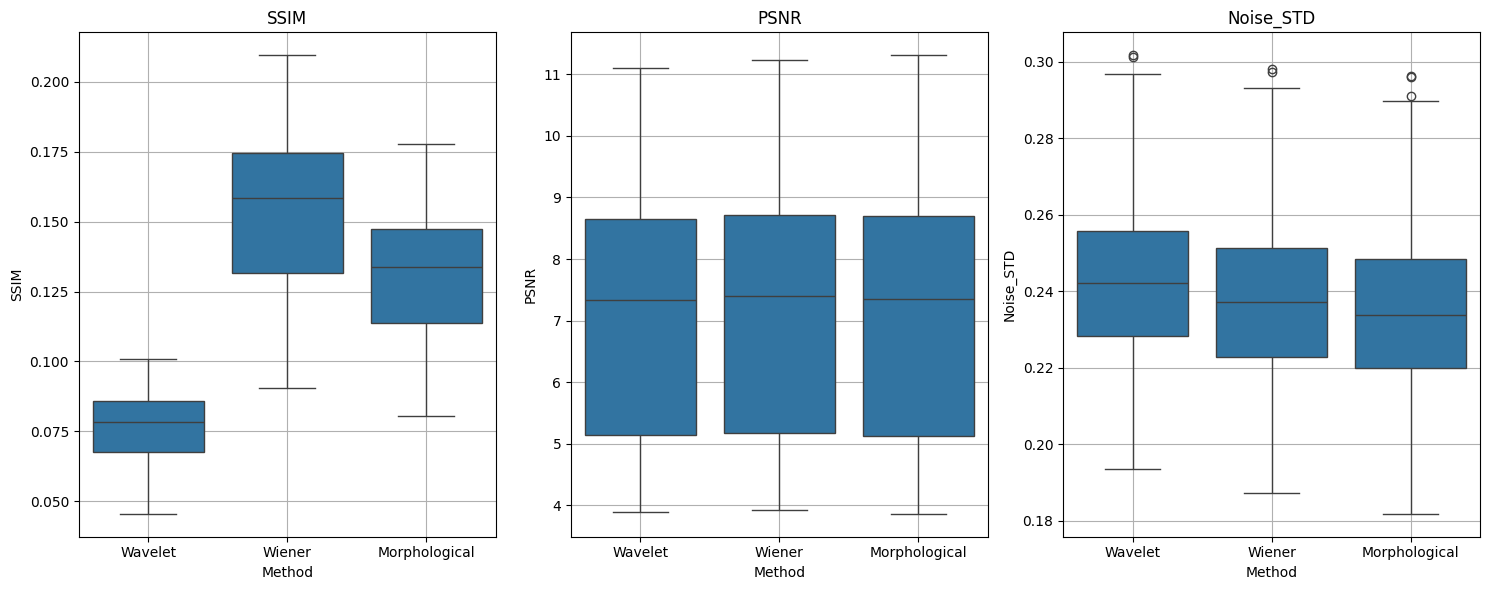

In [ ]:
us_folder_path = '/content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/us'
ct_folder_path = '/content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/ct'
df_results = analyze_denoising(us_folder_path, ct_folder_path)
plot_comparison(df_results)
df_results.to_csv('denoising_comparison.csv', index=False)

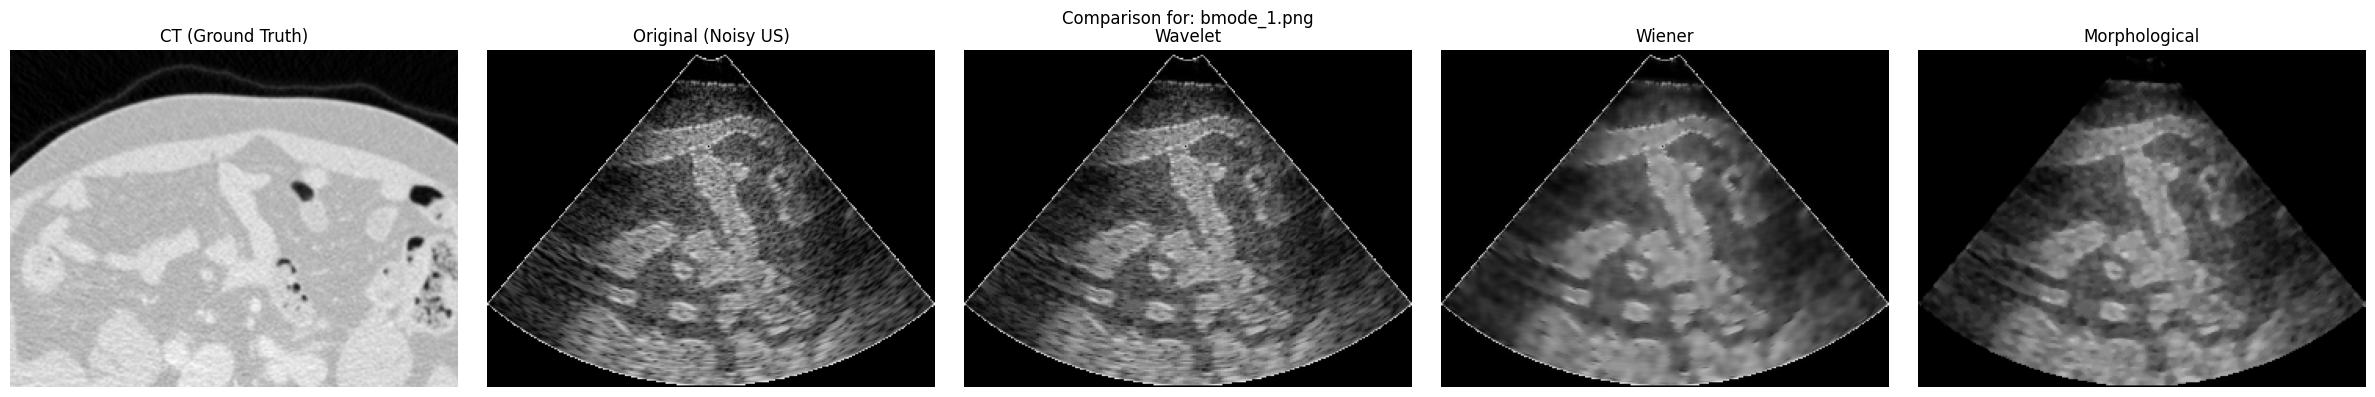

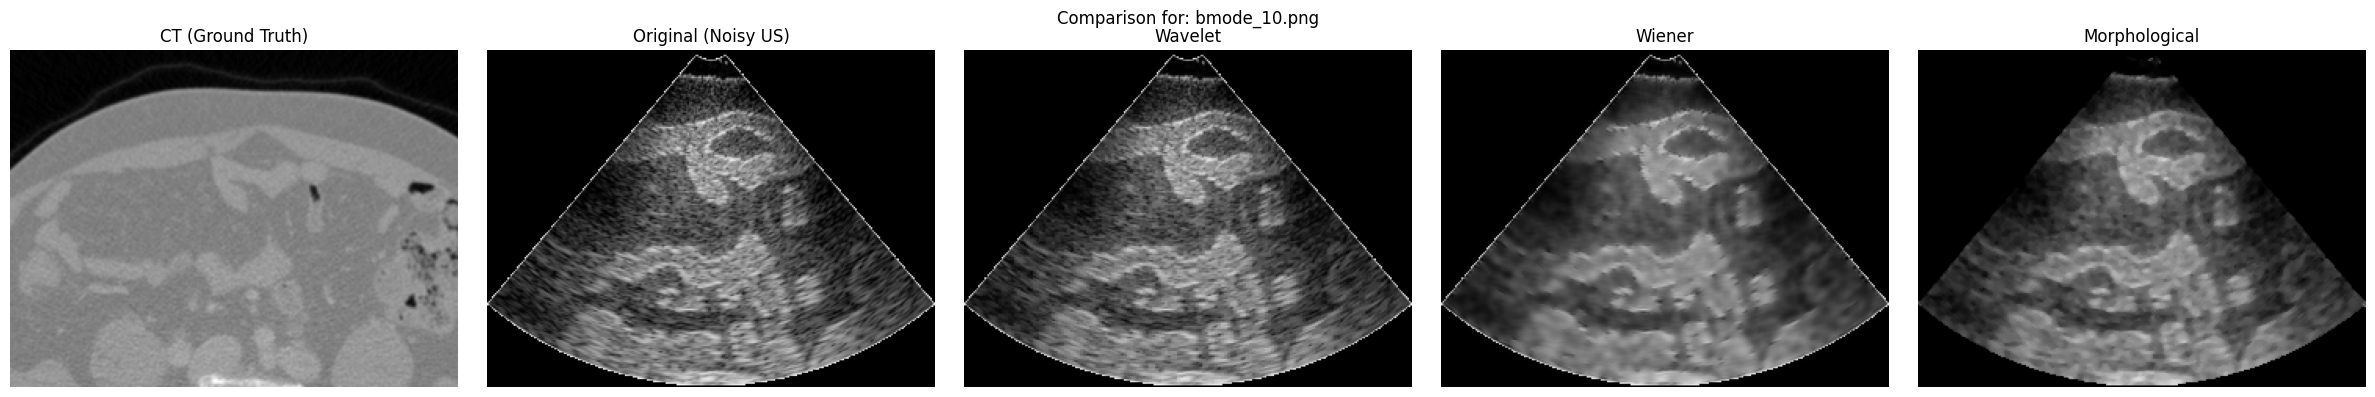

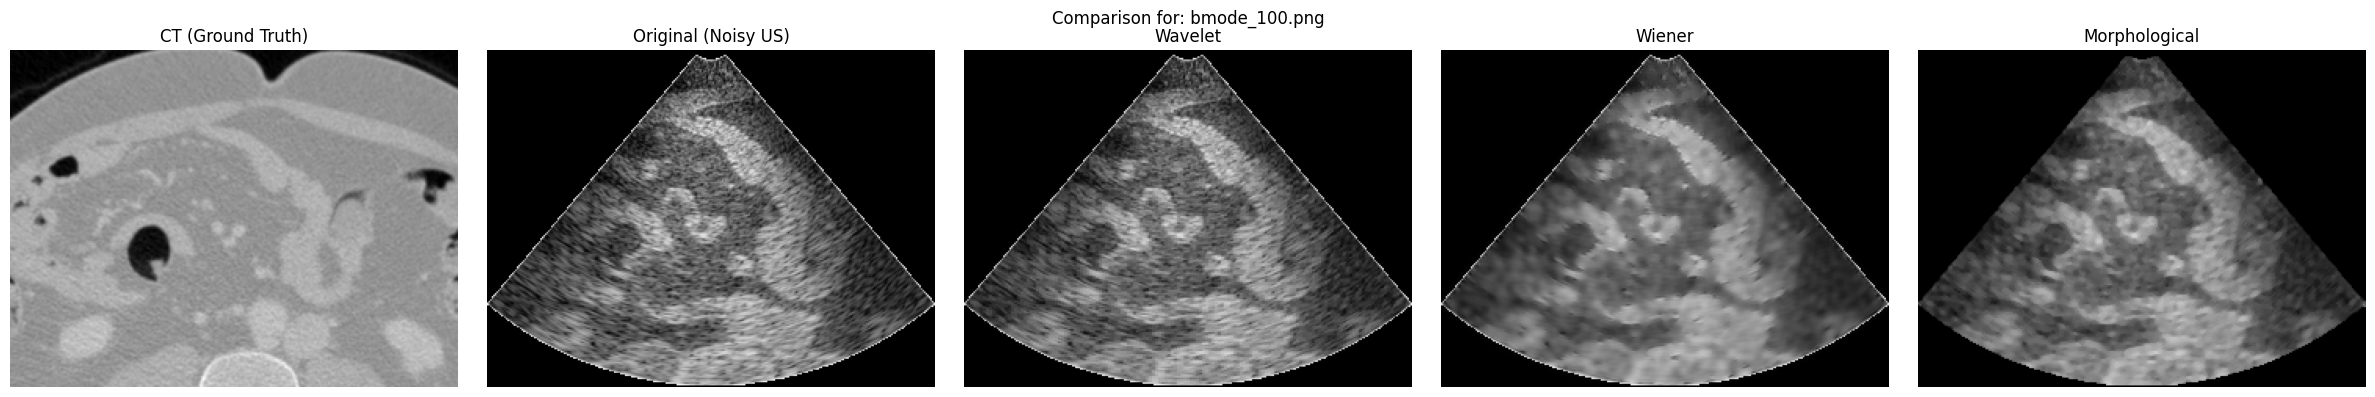

In [ ]:
from skimage.io import imread
from scipy.signal import wiener
from skimage.restoration import denoise_wavelet
from skimage.filters import rank
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
import os

def show_comparison_with_ct(us_folder_path, ct_folder_path, num_images=5):
    us_filenames = sorted([f for f in os.listdir(us_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    selem = disk(2)

    for us_file in us_filenames[:num_images]:
        # Derive corresponding CT file name
        index = ''.join(filter(str.isdigit, us_file))  # Extract number
        ct_file = f'ct_{index}.png'

        us_path = os.path.join(us_folder_path, us_file)
        ct_path = os.path.join(ct_folder_path, ct_file)

        if not os.path.exists(ct_path):
            print(f"Could not find CT image for {us_file} (expected {ct_file})")
            continue

        # Read images
        try:
            ct_img = imread(ct_path, as_gray=True).astype(np.float32)
            us_img = imread(us_path, as_gray=True).astype(np.float32)
        except Exception as e:
            print(f"Could not read {us_file} or {ct_file} - {e}")
            continue

        # Normalize to [0,1]
        ct_img /= 255.0 if ct_img.max() > 1 else 1.0
        us_img /= 255.0 if us_img.max() > 1 else 1.0

        # Apply filters
        wiener_filtered = np.clip(wiener(us_img, (5, 5)), 0, 1)
        morph_filtered = rank.median((us_img * 255).astype(np.uint8), footprint=selem).astype(np.float32) / 255.0
        wavelet_filtered = denoise_wavelet(us_img, method='BayesShrink', mode='soft', wavelet_levels=3, rescale_sigma=True)

        # Plot
        plt.figure(figsize=(24, 4))
        plt.suptitle(f"Comparison for: {us_file}", fontsize=12)

        plt.subplot(1, 5, 1)
        plt.imshow(ct_img, cmap='gray', vmin=0, vmax=1)
        plt.title('CT (Ground Truth)')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(us_img, cmap='gray', vmin=0, vmax=1)
        plt.title('Original (Noisy US)')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(wavelet_filtered, cmap='gray', vmin=0, vmax=1)
        plt.title('Wavelet')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(wiener_filtered, cmap='gray', vmin=0, vmax=1)
        plt.title('Wiener')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(morph_filtered, cmap='gray', vmin=0, vmax=1)
        plt.title('Morphological')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

us_folder_path = '/content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/us'
ct_folder_path = '/content/rus_sim1.0/ct2us/dataset/ct_slices_trans_06-Mar-2024/ct'

show_comparison_with_ct(us_folder_path, ct_folder_path, num_images=3)